In [7]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [29]:
path = "D:/data/SiPM/waveforms/20240506/pos_scan_line/"
filename_list = glob.glob(path + "Am241_28V_*.pkl")
template_file = "Am241_28V_x0.0_y0.0_*.pkl"
ov=28

In [30]:
def parse_position(fname):
    file_parts = fname[:-4].split("_")
    x, y = float(file_parts[-3][1:]), float(file_parts[-2][1:])
    return x,y

In [33]:
ovs_dict = {}

ov_list = [ov]

fsample = 62.5e6 ## sampling rate in Hz
record_length = 129 ## not clear why this differs from the 128 set above
time_vec = np.arange(0, record_length/fsample, 1/fsample)

for j,ov in enumerate(ov_list):
    
    curr_files = glob.glob(os.path.join(path, template_file))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(time_vec)	
                
                ## subtract baseline
                baseline = 2048 

                channel_dict = {}
                for k, ch in enumerate(range(16,-1,-2)):
                    channel_dict[k] = wf[ch] - baseline
                    sum_waveform += (wf[ch] - baseline)

                channel_dict[9] = sum_waveform

                data_dict[wfidx] = channel_dict
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + template_file)
    data_dict['time'] = time_vec*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}

Got 10230 waveforms for 10 files: Am241_28V_x0.0_y0.0_*.pkl


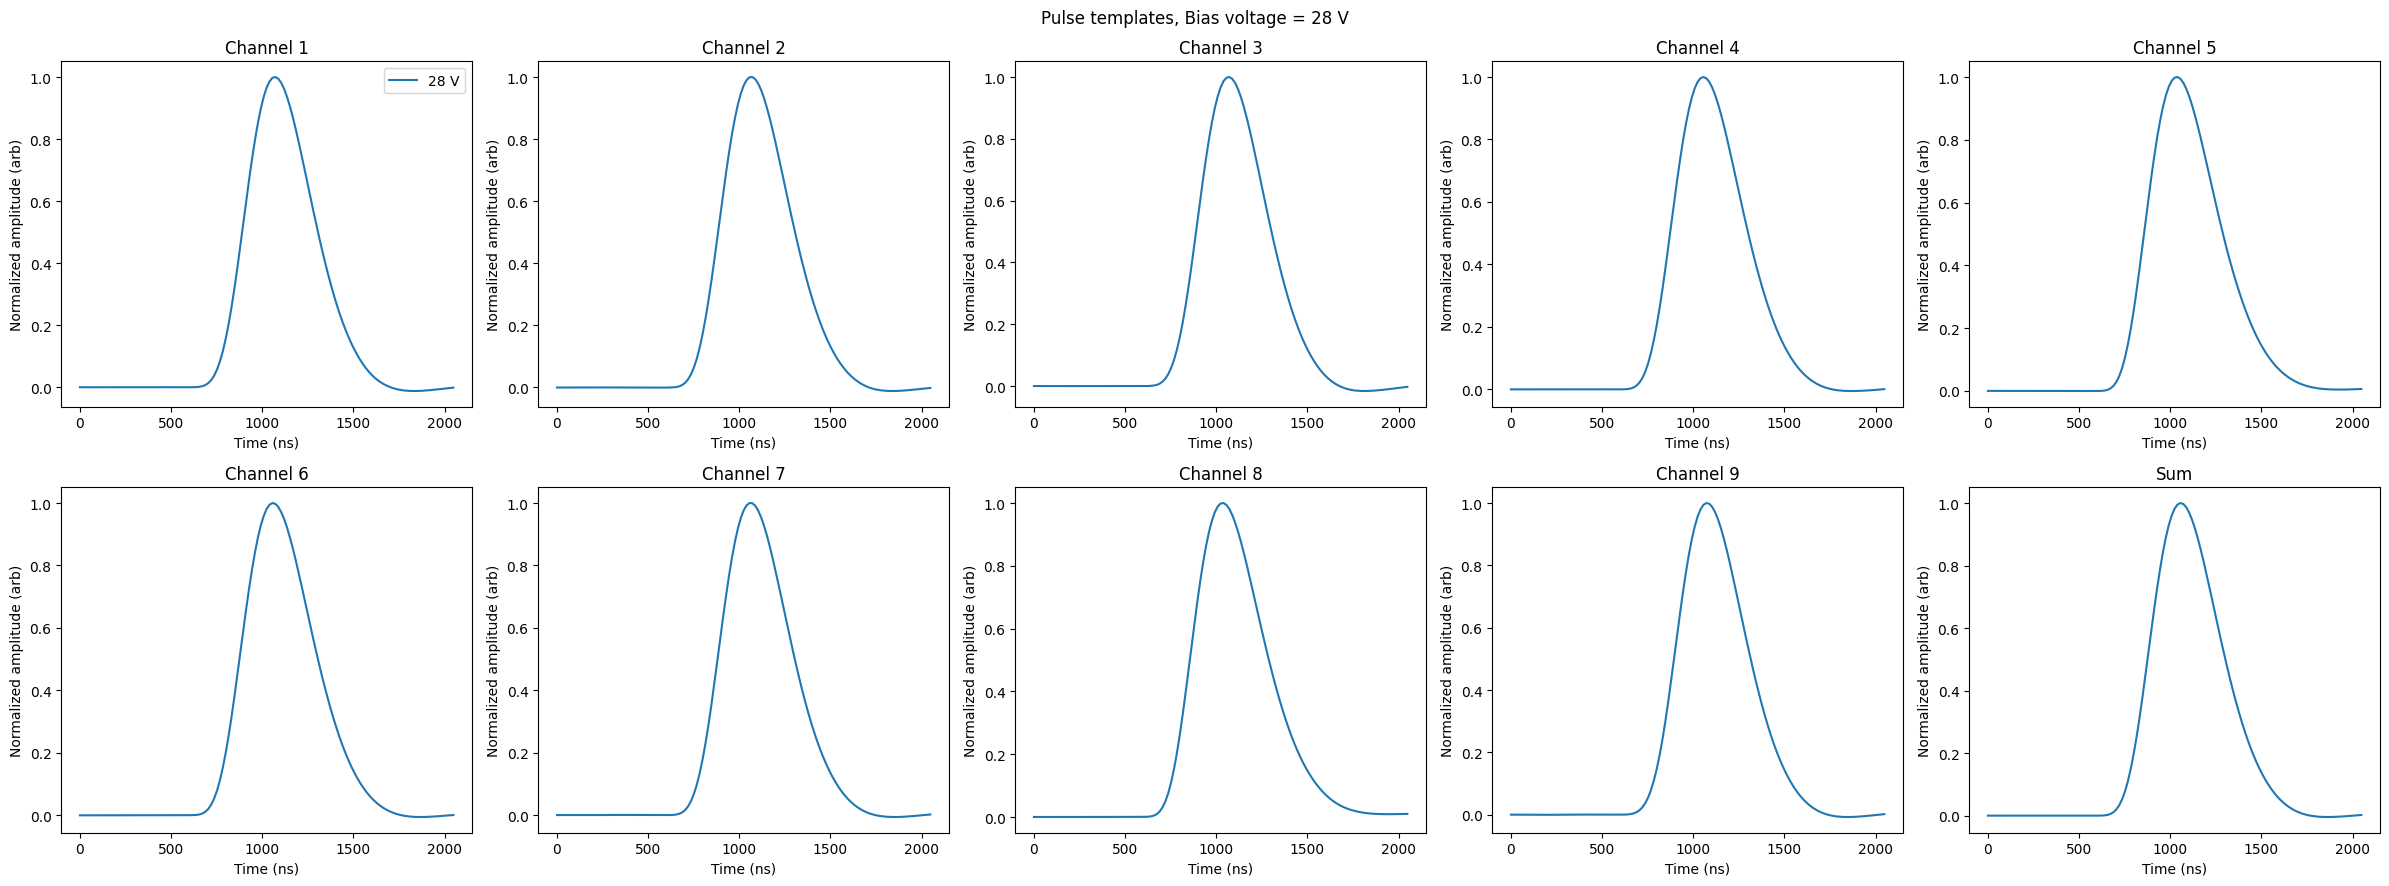

In [34]:
template_ch_dict = {}

min_vals = [200, 2000]

for ov in ov_list:

    plt.figure(figsize=(24,9))

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template_dict = {}
    nwfm = np.zeros(10)
    for ch in range(10):
        template_dict[ch] = np.zeros(len(data_dict['time']))

    for j in range(nwaveforms):

        cdat = data_dict[j]

        for ch in range(10):

            ## throw out bad traces
            min_val = min_vals[0] if ch < 9 else min_vals[1]
            if np.max(cdat[ch]) < min_val:
                continue

            template_dict[ch] += cdat[ch]
            nwfm[ch] += 1

    for ch in range(10):
        plt.subplot(2,5,ch+1)
        template_dict[ch] /= nwfm[ch]
        template_dict[ch] -= np.median(template_dict[ch][:20])
        template_dict[ch] /= np.max(template_dict[ch])

        plt.plot(data_dict['time'], template_dict[ch], label="%s V"%str(ov))
        plt.xlabel('Time (ns)')
        plt.ylabel('Normalized amplitude (arb)')

        if(ch < 9):
            plt.title("Channel %d"%(ch+1))
        else:
            plt.title("Sum")

    template_ch_dict[ov] = template_dict

    plt.suptitle("Pulse templates, Bias voltage = %s V"%str(ov))
    plt.subplot(2,5,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [35]:
xval_list = []
yval_list = []

for fidx, fname in enumerate(filename_list):

    xpos, ypos = parse_position(fname)

    if xpos not in xval_list:
        xval_list.append(xpos)

    if ypos not in yval_list:
        yval_list.append(ypos)

xval_list, yval_list = sorted(xval_list), sorted(yval_list)

print(xval_list, yval_list)


[-8.0, -7.0, -6.0, -5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0] [0.0]


In [45]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [46]:
def gauss_and_noise(x, A, mu, sigma, An, noise_cts):
    noise_vals = An * noise_cts
    return A*np.exp(-(x-mu)**2/(2*sigma**2)) + noise_vals

scanning +/-15 points


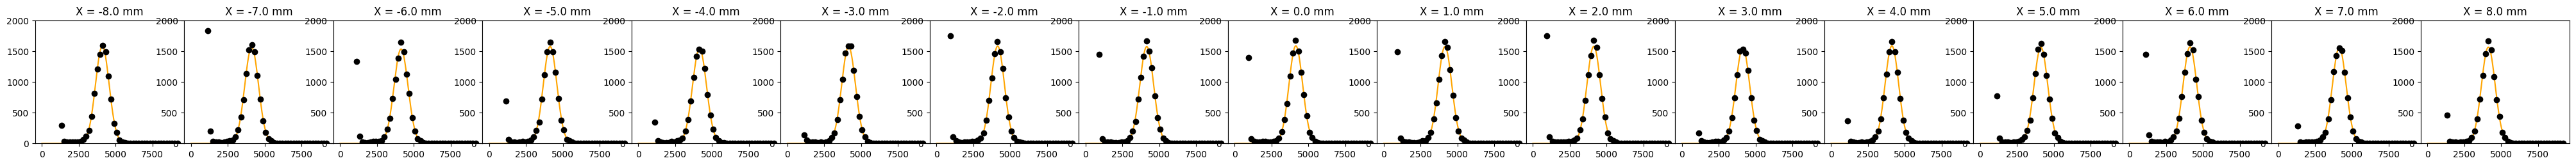

In [60]:
nrows = len(yval_list)
ncols = len(xval_list)

fit_vals = np.zeros((nrows, ncols))

plt.figure(figsize=(ncols*3,nrows*2.5))
remake_files = False

tscan = 500 ## time to scan around the template in ns
pts_to_scan = int(tscan*1e-9 * fsample * 0.5)
print("scanning +/-%d points"%pts_to_scan)

window  = [800, 1300]

for xidx, xpos in enumerate(xval_list):
    for yidx, ypos in enumerate(yval_list):

        if(remake_files):

            data_dict = {}
            wfidx = 0
            for fidx, fname in enumerate(filename_list):

                curr_xpos, curr_ypos = parse_position(fname)

                if(curr_xpos != xpos or curr_ypos != ypos):
                    continue

                with open(fname, 'rb') as fin:
                    curr_dict = pickle.load(fin)
                    for wf in curr_dict:
                        sum_waveform = np.zeros_like(time_vec)	
                        ## subtract baseline
                        baseline = 2048 
                        channel_dict = {}
                        for k, ch in enumerate(range(16,-1,-2)):
                            channel_dict[k] = wf[ch] - baseline
                            sum_waveform += (wf[ch] - baseline)

                        channel_dict[9] = sum_waveform

                        data_dict[wfidx] = channel_dict
                        wfidx += 1

            nwaveforms = wfidx
            print("Got %d waveforms"%nwaveforms + " for position: %.1f, %.1f"%(xpos, ypos))
            data_dict['time'] = time_vec*1e9

            mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

            recon_amps_max = []   
            recon_amps_fit = []   
            
            for k in data_dict.keys():
                if k == 'time': continue

                cdat_dict = data_dict[k]
                
                channel_max = np.zeros(10)
                channel_fit = np.zeros(10)
                for ch in range(10):

                    cdat = cdat_dict[ch]

                    shortened_temp = template_ch_dict[ov][ch][pts_to_scan:-pts_to_scan]

                    #fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)
                    fit_all = np.correlate(cdat, shortened_temp) / np.sum(shortened_temp**2)
                    fit = np.max(np.abs(fit_all))

                    midx = np.argmax(np.abs(cdat[mpts]))
                    max_val = cdat[mpts][midx]
                    
                    channel_max[ch] = max_val
                    channel_fit[ch] = fit
                
                recon_amps_max.append(channel_max)
                recon_amps_fit.append(channel_fit)

            np.savez( os.path.join(path, "recon_amps_%.1fV_%.1f_%.1f.npz"%(ov,xpos,ypos)), recon_amps_max=recon_amps_max, 
                                                                                      recon_amps_fit=recon_amps_fit,
                                                                                      nwaveforms=nwaveforms)
    
        else:
            data = np.load( os.path.join(path, "recon_amps_%.1fV_%.1f_%.1f.npz"%(ov,xpos,ypos)) )
            recon_amps_max = data['recon_amps_max']
            recon_amps_fit = data['recon_amps_fit']
            nwaveforms = data['nwaveforms']

        bins = np.linspace(0,12000 * (ov-24.7)/4.3, 50)
        bc = bins[:-1] + np.diff(bins)

        amps = recon_amps_fit
        h_fit, be = np.histogram( amps, bins=bins )

        fpts = bc > 2000
        errs = np.sqrt(h_fit[fpts])
        errs[errs==0] = 1
        spars = [np.max(h_fit), np.median(amps), np.std(amps)]
        gc_fit, _ = curve_fit(gauss, bc[fpts], h_fit[fpts], p0=spars, sigma=errs)

        eng_cal_fac = 1
        norm = 1
        xx = np.linspace(0, bc[-1], 1000)

        plt.subplot(nrows, ncols, yidx*ncols + xidx + 1)
        plt.errorbar(bc*eng_cal_fac, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko')
        plt.plot(xx*eng_cal_fac, gauss(xx, *gc_fit)/norm, 'orange')
        plt.ylim(0,2000)

    if(yidx > 0):
        plt.gca().set_yticks([]) 
    else:
        plt.title("X = %.1f mm"%xpos)   
    if(xidx < nrows-1):
        plt.gca().set_xticks([])
    #if(row_idx == len())
    #plt.xlabel("Uncalib. pulse height (mV)")
    #plt.ylabel("Counts/s")
    #plt.title("Max of waveform")

#plt.subplot(1,2,1)
#plt.legend()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

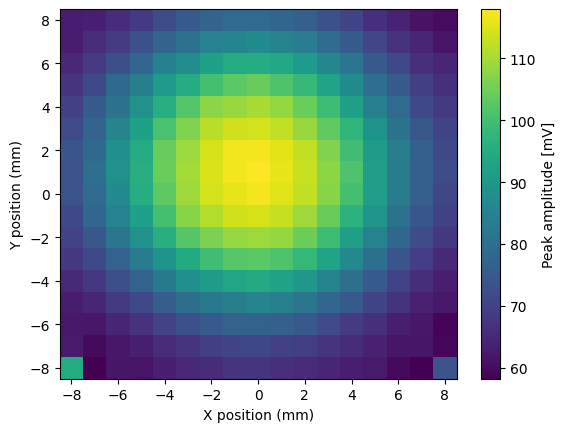

In [60]:
plt.figure()
plt.pcolormesh(xval_list, yval_list, fit_vals, shading='nearest')

plt.xlabel("X position (mm)")
plt.ylabel("Y position (mm)")

plt.colorbar(label="Peak amplitude [mV]")